In [22]:
import sys
import sqlite3

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import RFECV, RFE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns

In [23]:
sys.path.append('/home/pooya/w/DroughtMonitoringIran/')

DATABASE_PATH = "./database/database.db"

conn = sqlite3.connect(DATABASE_PATH)

data = pd.read_sql(sql='SELECT * FROM data', con=conn)

conn.close()

In [ ]:
di = 'SPEI'
di_scale = 18

selected_columns = [
    'Station_Name', 'Station_ID',
    'Station_Latitude', 'Station_Longitude', 'Station_Elevation',
    'Date',
    f'{di}_{di_scale}',
    'GPM_Precipitation',
    'PET_MOD16A2GF',
    'NDVI', 'EVI',
    'LSTDay', 'LSTNight', 'LST',
    'PCI_GPM', 'VCI', 'TCI', 'VHI', 'CI_GPM',
 ]

In [4]:
df = data.filter(items=selected_columns)
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Station_ID'] = df['Station_ID'].astype('category')
df['Year'] = df['Year'].astype('category')
df['Month'] = df['Month'].astype('category')

In [5]:
# selected_stations = ['Ramsar', 'Nowshahr']
selected_stations = ['Siahbisheh', 'Kiyasar', 'Kojur', 'Baladeh', 'Alasht']
# selected_stations = ['Babolsar', 'Gharakhil', 'Sari', 'Sari (dasht-e-naz airport)', 'Galugah', 'Bandar-e-amirabad', 'Amol', 'Polsefid']

start_date = '2006-09'
end_date = '2023-10'

df = df.query("Station_Name in @selected_stations and Date >= @start_date and Date < @end_date")

In [6]:
df.dropna(inplace=True)
df.sort_values(by=['Station_ID', 'Year', 'Month'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_24,GPM_Precipitation,PET_MOD16A2GF,NDVI,...,LSTDay,LSTNight,LST,PCI_GPM,VCI,TCI,VHI,CI_GPM,Year,Month
0,Siahbisheh,40735,36.231,51.303,1855.4,2008-08-01,0.428,13.392,253.712,0.365,...,37.99,11.99,24.990,0.129,0.000,0.175,0.088,0.102,2008,8
1,Siahbisheh,40735,36.231,51.303,1855.4,2008-09-01,0.510,48.960,190.988,0.279,...,31.65,9.23,20.440,0.760,0.000,0.560,0.280,0.440,2008,9
2,Siahbisheh,40735,36.231,51.303,1855.4,2008-10-01,0.310,73.656,112.550,0.245,...,25.58,5.74,15.660,0.575,0.000,0.458,0.229,0.344,2008,10
3,Siahbisheh,40735,36.231,51.303,1855.4,2008-11-01,0.109,63.360,60.075,0.178,...,11.06,-1.74,4.660,0.328,0.150,0.387,0.269,0.288,2008,11
4,Siahbisheh,40735,36.231,51.303,1855.4,2008-12-01,0.181,88.536,50.588,0.243,...,-5.06,-4.76,-4.910,1.000,0.628,0.917,0.773,0.848,2008,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,Alasht,99361,36.071,52.843,1805.0,2023-05-01,-2.034,34.224,201.938,0.469,...,30.68,11.31,20.995,0.441,0.000,0.141,0.070,0.194,2023,5
906,Alasht,99361,36.071,52.843,1805.0,2023-06-01,-1.778,29.520,247.350,0.461,...,29.42,13.02,21.220,0.462,0.236,0.836,0.536,0.511,2023,6
907,Alasht,99361,36.071,52.843,1805.0,2023-07-01,-1.888,15.624,259.525,0.466,...,31.65,14.71,23.180,0.215,0.573,0.767,0.670,0.518,2023,7
908,Alasht,99361,36.071,52.843,1805.0,2023-08-01,-1.978,20.088,239.275,0.420,...,34.26,14.97,24.615,0.222,0.537,0.274,0.406,0.345,2023,8


In [7]:
df[f'{di}_{di_scale}_Class'] = pd.cut(df[f'{di}_{di_scale}'], bins=[-10, -2, -1.5, -1, 1, 1.5, 2, 10], labels=['ED', 'SD', 'MD', 'NN', 'MW', 'VW', 'EW'])
df[f'{di}_{di_scale}_Class'] = df[f'{di}_{di_scale}_Class'].astype('category')
df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_24,GPM_Precipitation,PET_MOD16A2GF,NDVI,...,LSTNight,LST,PCI_GPM,VCI,TCI,VHI,CI_GPM,Year,Month,SPEI_24_Class
0,Siahbisheh,40735,36.231,51.303,1855.4,2008-08-01,0.428,13.392,253.712,0.365,...,11.99,24.990,0.129,0.000,0.175,0.088,0.102,2008,8,NN
1,Siahbisheh,40735,36.231,51.303,1855.4,2008-09-01,0.510,48.960,190.988,0.279,...,9.23,20.440,0.760,0.000,0.560,0.280,0.440,2008,9,NN
2,Siahbisheh,40735,36.231,51.303,1855.4,2008-10-01,0.310,73.656,112.550,0.245,...,5.74,15.660,0.575,0.000,0.458,0.229,0.344,2008,10,NN
3,Siahbisheh,40735,36.231,51.303,1855.4,2008-11-01,0.109,63.360,60.075,0.178,...,-1.74,4.660,0.328,0.150,0.387,0.269,0.288,2008,11,NN
4,Siahbisheh,40735,36.231,51.303,1855.4,2008-12-01,0.181,88.536,50.588,0.243,...,-4.76,-4.910,1.000,0.628,0.917,0.773,0.848,2008,12,NN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,Alasht,99361,36.071,52.843,1805.0,2023-05-01,-2.034,34.224,201.938,0.469,...,11.31,20.995,0.441,0.000,0.141,0.070,0.194,2023,5,ED
906,Alasht,99361,36.071,52.843,1805.0,2023-06-01,-1.778,29.520,247.350,0.461,...,13.02,21.220,0.462,0.236,0.836,0.536,0.511,2023,6,SD
907,Alasht,99361,36.071,52.843,1805.0,2023-07-01,-1.888,15.624,259.525,0.466,...,14.71,23.180,0.215,0.573,0.767,0.670,0.518,2023,7,SD
908,Alasht,99361,36.071,52.843,1805.0,2023-08-01,-1.978,20.088,239.275,0.420,...,14.97,24.615,0.222,0.537,0.274,0.406,0.345,2023,8,SD


In [8]:
cols_to_lag = ['GPM_Precipitation', 'PET_MOD16A2GF', 'NDVI', 'EVI', 'VHI', 'LST', 'PCI_GPM', 'TCI', 'VHI', 'CI_GPM']
for lag in range(1, 4):
    for col in cols_to_lag:
        # Important: Group by Station_ID to prevent data leakage across stations
        df[f'{col}_lag_{lag}'] = df.groupby('Station_ID', observed=False)[col].shift(lag)

df

,Station_Name,Station_ID,Station_Latitude,Station_Longitude,Station_Elevation,Date,SPEI_24,GPM_Precipitation,PET_MOD16A2GF,NDVI,...,CI_GPM_lag_2,GPM_Precipitation_lag_3,PET_MOD16A2GF_lag_3,NDVI_lag_3,EVI_lag_3,VHI_lag_3,LST_lag_3,PCI_GPM_lag_3,TCI_lag_3,CI_GPM_lag_3
0,Siahbisheh,40735,36.231,51.303,1855.4,2008-08-01,0.428,13.392,253.712,0.365,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Siahbisheh,40735,36.231,51.303,1855.4,2008-09-01,0.510,48.960,190.988,0.279,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Siahbisheh,40735,36.231,51.303,1855.4,2008-10-01,0.310,73.656,112.550,0.245,...,0.102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Siahbisheh,40735,36.231,51.303,1855.4,2008-11-01,0.109,63.360,60.075,0.178,...,0.440,13.392,253.712,0.365,0.193,0.088,24.990,0.129,0.175,0.102
4,Siahbisheh,40735,36.231,51.303,1855.4,2008-12-01,0.181,88.536,50.588,0.243,...,0.344,48.960,190.988,0.279,0.154,0.280,20.440,0.760,0.560,0.440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,Alasht,99361,36.071,52.843,1805.0,2023-05-01,-2.034,34.224,201.938,0.469,...,0.116,55.776,105.225,0.252,0.117,0.479,4.975,0.401,0.447,0.453
906,Alasht,99361,36.071,52.843,1805.0,2023-06-01,-1.778,29.520,247.350,0.461,...,0.200,45.384,142.175,0.291,0.134,0.043,12.915,0.264,0.000,0.116
907,Alasht,99361,36.071,52.843,1805.0,2023-07-01,-1.888,15.624,259.525,0.466,...,0.194,23.760,178.512,0.459,0.252,0.210,17.015,0.180,0.012,0.200
908,Alasht,99361,36.071,52.843,1805.0,2023-08-01,-1.978,20.088,239.275,0.420,...,0.511,34.224,201.938,0.469,0.287,0.070,20.995,0.441,0.141,0.194


In [9]:
for col in cols_to_lag:
    # روش محاسبه با استفاده از transform اصلاح شد تا از خطا جلوگیری شود
    df[f'{col}_roll_mean_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
    df[f'{col}_roll_std_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())


/tmp/ipykernel_410488/572975484.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'{col}_roll_mean_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
/tmp/ipykernel_410488/572975484.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'{col}_roll_std_3'] = df.groupby('Station_ID')[col].transform(lambda x: x.rolling(window=3, min_periods=1).std())
/tmp/ipykernel_410488/572975484.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

In [10]:
# df.dropna(inplace=True)
# df.reset_index(drop=True, inplace=True)

# X = df.drop(
#     columns=[
#         'Station_Name',
#         'Station_ID',
#         'Date',
#         'Year',
#         f'{di}_{di_scale}',
#         f'{di}_{di_scale}_Class',
#     ]
# )

# y = df[f'{di}_{di_scale}']


df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

X = df.drop(
    columns=[
        'Station_Name',
        'Station_ID',
        'Date',
        'Year',
        f'{di}_{di_scale}',
        f'{di}_{di_scale}_Class',
    ]
)

y = df[f'{di}_{di_scale}_Class']

In [11]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=X['Month'] # Stratify by the 'Month' column
# )

# print("\n--- Data Shapes ---")
# print(f"Training features shape: {X_train.shape}")
# print(f"Testing features shape:  {X_test.shape}")

# # --- 4. Hyperparameter Tuning with XGBoost ---
# print("\n--- Starting Hyperparameter Tuning for XGBoost ---")
# # Define the parameter grid to search
# param_grid = {
#     'n_estimators': [100, 300, 500, 1000],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'max_depth': [3, 5, 7, 9],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9],
#     'gamma': [0, 0.1, 0.2]
# }

# # Initialize the XGBoost regressor with categorical feature support enabled
# xgb_reg = xgb.XGBRegressor(
#     objective='reg:squarederror', 
#     n_jobs=-1, 
#     random_state=42, 
#     enable_categorical=True  # <-- FIX: Enable support for categorical features
# )

# # Using a standard 5-fold cross-validation since the split is now random
# random_search = RandomizedSearchCV(
#     estimator=xgb_reg,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     cv=5, 
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# best_model = random_search.best_estimator_

# # --- 6. Prediction and Evaluation ---
# y_pred = best_model.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (XGBoost with Stratified Split) ---")
# print(f"R-squared (R²): {r2:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# plt.figure(figsize=(12, 10))
# xgb.plot_importance(best_model, importance_type='weight', ax=plt.gca(), max_num_features=20)
# plt.title('Top 20 Feature Importances for SPI-3 Prediction (XGBoost)', fontsize=16)
# plt.xlabel('Weight (Frequency of Use in Trees)', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Actual vs. Predicted Scatter Plot
# plt.figure(figsize=(8, 8))
# plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', c='royalblue')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
# plt.title('Actual vs. Predicted SPI-3 (Optimized XGBoost)', fontsize=16)
# plt.xlabel('Actual SPI-3', fontsize=12)
# plt.ylabel('Predicted SPI-3', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.axis('equal')
# plt.show()

In [12]:
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=X['Month']
# )

# print("\n--- Data Shapes ---")
# print(f"Training features shape: {X_train.shape}")
# print(f"Testing features shape:  {X_test.shape}")

# # --- 4. Hyperparameter Tuning with Random Forest ---
# print("\n--- Starting Hyperparameter Tuning for Random Forest ---")
# # Define the parameter grid for Random Forest
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 1.0]
# }

# # Initialize the Random Forest regressor
# rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

# # Set up RandomizedSearchCV
# random_search = RandomizedSearchCV(
#     estimator=rf_reg,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train, y_train)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# best_model = random_search.best_estimator_

# # --- 6. Prediction and Evaluation ---
# y_pred = best_model.predict(X_test)

# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (Random Forest with Stratified Split) ---")
# print(f"R-squared (R²): {r2:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# plt.figure(figsize=(12, 10))
# sns.barplot(x=feature_importances.head(20), y=feature_importances.head(20).index)
# plt.title('Top 20 Feature Importances for SPI-3 Prediction (Random Forest)', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Actual vs. Predicted Scatter Plot
# plt.figure(figsize=(8, 8))
# plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', c='seagreen')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
# plt.title('Actual vs. Predicted SPI-3 (Optimized Random Forest)', fontsize=16)
# plt.xlabel('Actual SPI-3', fontsize=12)
# plt.ylabel('Predicted SPI-3', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.axis('equal')
# plt.show()

In [13]:
# import pandas as pd
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import RandomizedSearchCV, train_test_split
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.preprocessing import StandardScaler
# from sklearn.linear_model import LassoCV
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- 3a. Stratified Random Split based on Month ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=X['Month']
# )

# # --- 3b. Automatic Feature Selection using LassoCV ---
# print("\n--- Performing Feature Selection with LassoCV ---")
# # Lasso is sensitive to feature scaling, so we scale the data first
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Use LassoCV to find the best alpha and fit the model
# lasso = LassoCV(cv=5, random_state=42, n_jobs=-1).fit(X_train_scaled, y_train)

# # Get the absolute value of the coefficients to determine importance
# importance = np.abs(lasso.coef_)

# # Select the top N features based on the largest coefficients
# # You can change this number to 5, 6, or any other value.
# num_features_to_select = 6
# top_feature_indices = np.argsort(importance)[-num_features_to_select:]
# selected_features = X_train.columns[top_feature_indices]

# print(f"Selected top {num_features_to_select} features out of {X_train.shape[1]}")
# print("Selected features:", list(selected_features))

# # Create new dataframes with only the selected features
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]


# print("\n--- Data Shapes After Feature Selection ---")
# print(f"Training features shape: {X_train_selected.shape}")
# print(f"Testing features shape:  {X_test_selected.shape}")

# # --- 4. Hyperparameter Tuning with Random Forest ---
# print("\n--- Starting Hyperparameter Tuning on Selected Features ---")
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 1.0]
# }

# rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

# random_search = RandomizedSearchCV(
#     estimator=rf_reg,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='neg_root_mean_squared_error',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # Fit the search on the data with selected features
# random_search.fit(X_train_selected, y_train)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# best_model = random_search.best_estimator_

# # --- 6. Prediction and Evaluation ---
# y_pred = best_model.predict(X_test_selected)

# r2 = r2_score(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))
# mae = mean_absolute_error(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (Random Forest with Lasso Selection) ---")
# print(f"R-squared (R²): {r2:.4f}")
# print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
# print(f"Mean Absolute Error (MAE): {mae:.4f}")

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)

# plt.figure(figsize=(12, 10))
# sns.barplot(x=feature_importances, y=feature_importances.index)
# plt.title(f'Feature Importances for Top {num_features_to_select} Features (Random Forest)', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Actual vs. Predicted Scatter Plot
# plt.figure(figsize=(8, 8))
# plt.scatter(y_test, y_pred, alpha=0.6, edgecolors='k', c='seagreen')
# plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', lw=2, label='Perfect Prediction')
# plt.title('Actual vs. Predicted SPI-3 (Optimized Random Forest)', fontsize=16)
# plt.xlabel('Actual SPI-3', fontsize=12)
# plt.ylabel('Predicted SPI-3', fontsize=12)
# plt.legend()
# plt.grid(True)
# plt.axis('equal')
# plt.show()


In [14]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV, train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns


# # --- 3a. Stratified Random Split based on Target Class ---
# # We stratify by 'y' to ensure each class is proportionally represented
# # in both the training and testing sets.
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 3b. Automatic Feature Selection using RandomForestClassifier ---
# print("\n--- Performing Feature Selection ---")
# # Train a preliminary classifier to get feature importances
# fs_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# fs_model.fit(X_train, y_train)

# # Get feature importances
# importance = fs_model.feature_importances_

# # Select the top N features
# num_features_to_select = 8
# top_feature_indices = np.argsort(importance)[-num_features_to_select:]
# selected_features = X_train.columns[top_feature_indices]

# print(f"Selected top {num_features_to_select} features out of {X_train.shape[1]}")
# print("Selected features:", list(selected_features))

# # Create new dataframes with only the selected features
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# print("\n--- Data Shapes After Feature Selection ---")
# print(f"Training features shape: {X_train_selected.shape}")
# print(f"Testing features shape:  {X_test_selected.shape}")

# # --- 4. Hyperparameter Tuning with Random Forest Classifier ---
# print("\n--- Starting Hyperparameter Tuning on Selected Features ---")
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 1.0],
#     'class_weight': ['balanced', 'balanced_subsample', None]
# }

# rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# random_search = RandomizedSearchCV(
#     estimator=rf_clf,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='accuracy', # Use a classification metric
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train_selected, y_train)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# best_model = random_search.best_estimator_

# # --- 6. Prediction and Evaluation ---
# y_pred = best_model.predict(X_test_selected)

# # Use classification metrics for evaluation
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (Random Forest Classifier) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)

# plt.figure(figsize=(12, 10))
# sns.barplot(x=feature_importances, y=feature_importances.index)
# plt.title(f'Feature Importances for Top {num_features_to_select} Features', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Confusion Matrix
# # This plot shows how the model performed on each class.
# cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
# plt.title('Confusion Matrix', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()


# RandomForestClassifier

In [15]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import RandomizedSearchCV, train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# # کتابخانه imblearn برای استفاده از SMOTE اضافه شد
# from imblearn.over_sampling import SMOTE
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- 3a. Stratified Random Split based on Target Class ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 3b. Automatic Feature Selection using RandomForestClassifier ---
# print("\n--- Performing Feature Selection ---")
# fs_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# fs_model.fit(X_train, y_train)
# importance = fs_model.feature_importances_
# num_features_to_select = 8
# top_feature_indices = np.argsort(importance)[-num_features_to_select:]
# selected_features = X_train.columns[top_feature_indices]
# print(f"Selected top {num_features_to_select} features out of {X_train.shape[1]}")
# print("Selected features:", list(selected_features))
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# # --- 4a. Balance the Training Data using SMOTE ---
# # این مرحله برای رفع مشکل عدم توازن کلاس ها اضافه شده است
# # SMOTE فقط باید روی داده های آموزشی اعمال شود
# print("\n--- Balancing training data with SMOTE ---")
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# print("Original training data shape:", y_train.value_counts().to_dict())
# print("Resampled training data shape:", pd.Series(y_train_resampled).value_counts().to_dict())


# # --- 4b. Hyperparameter Tuning with Random Forest Classifier ---
# print("\n--- Starting Hyperparameter Tuning on Resampled Data ---")
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2', 1.0],
#     'class_weight': ['balanced', 'balanced_subsample', None]
# }

# rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)

# # معیار ارزیابی به f1_macro تغییر یافت تا عملکرد روی همه کلاس ها بهینه شود
# random_search = RandomizedSearchCV(
#     estimator=rf_clf,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='f1_macro', # <-- تغییر کلیدی
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# # بهینه سازی روی داده های متوازن شده انجام می شود
# random_search.fit(X_train_resampled, y_train_resampled)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# best_model = random_search.best_estimator_
# # مدل نهایی نیز روی داده های متوازن شده آموزش می بیند
# best_model.fit(X_train_resampled, y_train_resampled)


# # --- 6. Prediction and Evaluation ---
# # ارزیابی نهایی روی داده های تست اصلی (دست نخورده) انجام می شود
# y_pred = best_model.predict(X_test_selected)

# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (Random Forest Classifier) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)
# plt.figure(figsize=(8, 6))
# sns.barplot(x=feature_importances, y=feature_importances.index)
# plt.title(f'Feature Importances for Top {num_features_to_select} Features', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Confusion Matrix
# cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
# plt.title('Confusion Matrix', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()


# LightGBM

In [16]:
# import pandas as pd
# # کتابخانه LightGBM اضافه شد
# import lightgbm as lgb
# from sklearn.model_selection import RandomizedSearchCV, train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# from imblearn.over_sampling import SMOTE
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # --- 3a. Stratified Random Split based on Target Class ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 3b. Automatic Feature Selection using LightGBM ---
# print("\n--- Performing Feature Selection ---")
# # برای رفع خطا، مدل مجبور به استفاده از یک هسته پردازنده می شود
# fs_model = lgb.LGBMClassifier(random_state=42, n_jobs=1)
# fs_model.fit(X_train, y_train)
# importance = fs_model.feature_importances_
# num_features_to_select = 6
# top_feature_indices = np.argsort(importance)[-num_features_to_select:]
# selected_features = X_train.columns[top_feature_indices]
# print(f"Selected top {num_features_to_select} features out of {X_train.shape[1]}")
# print("Selected features:", list(selected_features))
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# # --- 4a. Balance the Training Data using SMOTE ---
# print("\n--- Balancing training data with SMOTE ---")
# smote = SMOTE(random_state=42)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
# print("Resampled training data shape:", pd.Series(y_train_resampled).value_counts().to_dict())

# # --- 4b. Hyperparameter Tuning with LightGBM Classifier ---
# print("\n--- Starting Hyperparameter Tuning for LightGBM ---")
# param_grid = {
#     'n_estimators': [100, 200, 500],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'num_leaves': [20, 31, 40],
#     'max_depth': [-1, 5, 10],
#     'reg_alpha': [0, 0.1, 0.5],
#     'reg_lambda': [0, 0.1, 0.5],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'subsample': [0.7, 0.8, 1.0],
#     'class_weight': ['balanced', None]
# }

# # برای رفع خطا، مدل مجبور به استفاده از یک هسته پردازنده می شود
# lgb_clf = lgb.LGBMClassifier(random_state=42, n_jobs=1)

# random_search = RandomizedSearchCV(
#     estimator=lgb_clf,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='f1_macro',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     # برای جلوگیری از خطاهای احتمالی موازی سازی، این بخش نیز به یک هسته محدود می شود
#     n_jobs=1
# )

# random_search.fit(X_train_resampled, y_train_resampled)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# # مدل نهایی نیز با یک هسته اجرا می شود
# best_model = random_search.best_estimator_
# best_model.set_params(n_jobs=1) # اطمینان از اینکه مدل نهایی نیز با یک هسته اجرا می شود
# best_model.fit(X_train_resampled, y_train_resampled)

# # --- 6. Prediction and Evaluation ---
# y_pred = best_model.predict(X_test_selected)
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (LightGBM Classifier) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)
# plt.figure(figsize=(12, 10))
# sns.barplot(x=feature_importances, y=feature_importances.index)
# plt.title(f'Feature Importances for Top {num_features_to_select} Features (LightGBM)', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Confusion Matrix
# cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
# plt.title('Confusion Matrix (LightGBM)', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()

# CatBoost

In [17]:
# import pandas as pd
# # کتابخانه CatBoost اضافه شد
# from catboost import CatBoostClassifier
# from sklearn.model_selection import RandomizedSearchCV, train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from sklearn.preprocessing import StandardScaler
# # SMOTENC برای داده های ترکیبی (عددی و دسته ای) جایگزین SMOTE شد
# from imblearn.over_sampling import SMOTE, SMOTENC
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns


# # --- 3a. Stratified Random Split based on Target Class ---
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # --- 3b. Automatic Feature Selection using CatBoost ---
# print("\n--- Performing Feature Selection ---")
# categorical_features_indices_fs = np.where(X_train.dtypes == 'category')[0]

# fs_model = CatBoostClassifier(random_state=42, verbose=0)
# fs_model.fit(X_train, y_train, cat_features=categorical_features_indices_fs)
# importance = fs_model.feature_importances_
# num_features_to_select = 6
# top_feature_indices = np.argsort(importance)[-num_features_to_select:]
# selected_features = X_train.columns[top_feature_indices]
# print(f"Selected top {num_features_to_select} features out of {X_train.shape[1]}")
# print("Selected features:", list(selected_features))
# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# # --- 4a. Balance the Training Data using SMOTENC ---
# print("\n--- Balancing training data with SMOTE ---")
# categorical_features_in_selected = [i for i, col in enumerate(X_train_selected.columns) if X_train_selected[col].dtype.name == 'category']

# if not categorical_features_in_selected:
#     print("No categorical features selected. Using standard SMOTE.")
#     smote = SMOTE(random_state=42, k_neighbors=3)
# else:
#     print(f"Categorical features found at indices: {categorical_features_in_selected}. Using SMOTENC.")
#     smote = SMOTENC(categorical_features=categorical_features_in_selected, random_state=42, k_neighbors=3)

# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)
# print("Resampled training data shape:", pd.Series(y_train_resampled).value_counts().to_dict())

# # --- 4b. Hyperparameter Tuning with CatBoost Classifier ---
# print("\n--- Starting Hyperparameter Tuning for CatBoost ---")
# # پارامتر subsample به دلیل ناسازگاری با روش پیش فرض حذف شد
# param_grid = {
#     'iterations': [100, 200, 500],
#     'learning_rate': [0.01, 0.05, 0.1],
#     'depth': [4, 6, 8],
#     'l2_leaf_reg': [1, 3, 5, 7],
#     'auto_class_weights': ['Balanced', 'SqrtBalanced', None]
# }

# cat_clf = CatBoostClassifier(random_state=42, verbose=0)

# random_search = RandomizedSearchCV(
#     estimator=cat_clf,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='f1_macro',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# final_cat_features_indices = [i for i, col in enumerate(X_train_selected.columns) if col in ['Year', 'Month']]
# print(f"Categorical feature indices for final model: {final_cat_features_indices}")

# random_search.fit(X_train_resampled, y_train_resampled, cat_features=final_cat_features_indices)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Optimized Model Training ---
# print("\n--- Training Final Model with Optimal Parameters ---")
# best_model = random_search.best_estimator_
# best_model.fit(X_train_resampled, y_train_resampled, cat_features=final_cat_features_indices, verbose=0)

# # --- 6. Prediction and Evaluation ---
# y_pred = best_model.predict(X_test_selected)
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics (CatBoost Classifier) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)
# plt.figure(figsize=(12, 10))
# sns.barplot(x=feature_importances, y=feature_importances.index)
# plt.title(f'Feature Importances for Top {num_features_to_select} Features (CatBoost)', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Confusion Matrix
# cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
# plt.title('Confusion Matrix (CatBoost)', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()


# LSTM

In [18]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# # کتابخانه های مورد نیاز برای شبکه عصبی
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.callbacks import EarlyStopping
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler, LabelEncoder
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from imblearn.over_sampling import SMOTE
# from sklearn.ensemble import RandomForestClassifier

# # برای اطمینان از تکرارپذیری نتایج
# tf.random.set_seed(42)
# np.random.seed(42)

# # --- 2. Feature Engineering & Selection ---
# features_to_exclude = [
#     'Station_Name',
#     'Station_ID',
#     'Date',
#     'Year',
#     f'{di}_{di_scale}',
#     f'{di}_{di_scale}_Class'
# ]


# y_raw = df[f'{di}_{di_scale}_Class']
# X_raw = df.drop(columns=features_to_exclude, errors='ignore')

# # انتخاب ویژگی با یک مدل ساده تر
# fs_model = RandomForestClassifier(n_estimators=100, random_state=42)
# fs_model.fit(X_raw, y_raw)
# importance = fs_model.feature_importances_
# num_features_to_select = 6
# top_feature_indices = np.argsort(importance)[-num_features_to_select:]
# selected_features = X_raw.columns[top_feature_indices]
# print(f"\nSelected top {num_features_to_select} features:", list(selected_features))
# X = X_raw[selected_features]

# # --- 3. Data Preprocessing for LSTM ---
# # الف) تبدیل برچسب های رشته ای به عددی
# encoder = LabelEncoder()
# y_encoded = encoder.fit_transform(y_raw)
# n_classes = len(encoder.classes_)

# # ب) تقسیم داده ها
# X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# # ج) مقیاس بندی داده ها (بسیار مهم برای شبکه های عصبی)
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # د) متوازن سازی داده های آموزشی با SMOTE
# print("\nBalancing training data with SMOTE...")
# smote = SMOTE(random_state=42, k_neighbors=3)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# # ه) تغییر شکل داده ها برای ورودی LSTM
# # LSTM به ورودی سه بعدی نیاز دارد: [نمونه ها، گام های زمانی، ویژگی ها]
# # در اینجا، ما هر ماه را به صورت مستقل در نظر می گیریم (timesteps=1)
# X_train_reshaped = X_train_resampled.reshape((X_train_resampled.shape[0], 1, X_train_resampled.shape[1]))
# X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
# print(f"\nReshaped training data shape: {X_train_reshaped.shape}")

# # --- 4. Build the LSTM Model ---
# print("\nBuilding LSTM model...")
# model = Sequential()
# model.add(LSTM(units=50, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), return_sequences=True))
# model.add(Dropout(0.2))
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))
# model.add(Dense(units=n_classes, activation='softmax'))

# # کامپایل کردن مدل
# model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# model.summary()

# # --- 5. Train the Model ---
# print("\nTraining LSTM model...")
# # استفاده از EarlyStopping برای جلوگیری از بیش برازش (Overfitting)
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(
#     X_train_reshaped, 
#     y_train_resampled,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_test_reshaped, y_test),
#     callbacks=[early_stopping],
#     verbose=1
# )

# # --- 6. Prediction and Evaluation ---
# # پیش بینی روی داده های تست
# y_pred_probs = model.predict(X_test_reshaped)
# y_pred = np.argmax(y_pred_probs, axis=1)

# # برگرداندن برچسب های عددی به رشته ای برای گزارش
# y_test_labels = encoder.inverse_transform(y_test)
# y_pred_labels = encoder.inverse_transform(y_pred)

# accuracy = accuracy_score(y_test_labels, y_pred_labels)
# report = classification_report(y_test_labels, y_pred_labels)

# print("\n--- Final Model Evaluation Metrics (LSTM Classifier) ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 7. Visualization for Thesis ---
# sns.set_theme(style="whitegrid")

# # a) نمودار دقت و خطا در طول آموزش
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Training Accuracy')
# plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
# plt.title('Model Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.title('Model Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.tight_layout()
# plt.show()

# # b) Confusion Matrix
# cm = confusion_matrix(y_test_labels, y_pred_labels, labels=encoder.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
# plt.title('Confusion Matrix (LSTM)', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()


# RandomForestClassifier, Rolling Statistics, Recursive Feature Elimination (RFE)

In [19]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# # RFE برای انتخاب ویژگی اضافه شد
# from sklearn.feature_selection import RFE
# from sklearn.model_selection import RandomizedSearchCV, train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from imblearn.over_sampling import SMOTE
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns


# # --- 3. Data Splitting and Feature Selection ---
# # الف) تقسیم داده ها
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # ب) انتخاب ویژگی با RFE
# print("\n--- Performing Feature Selection with RFE ---")
# # مدل پایه برای RFE
# estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# # انتخاب 6 ویژگی برتر
# selector = RFE(estimator, n_features_to_select=6, step=1)
# selector = selector.fit(X_train, y_train)

# selected_features = X_train.columns[selector.support_]
# print(f"Selected {len(selected_features)} features via RFE:")
# print(list(selected_features))

# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# # --- 4. Balance and Tune Model ---
# # الف) متوازن سازی داده ها با SMOTE
# print("\n--- Balancing training data with SMOTE ---")
# min_class_size = y_train.value_counts().min()
# # تنظیم k_neighbors به یک عدد کمتر از کوچکترین کلاس (حداقل 1)
# k_neighbors = max(1, min_class_size - 1)
# smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# # ب) بهینه سازی هایپرپارامترها
# print("\n--- Starting Hyperparameter Tuning ---")
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': ['balanced', 'balanced_subsample', None]
# }

# rf_clf = RandomForestClassifier(random_state=42)
# random_search = RandomizedSearchCV(
#     estimator=rf_clf,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='f1_macro',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train_resampled, y_train_resampled)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Final Model Training and Evaluation ---
# print("\n--- Training Final Model ---")
# best_model = random_search.best_estimator_
# best_model.fit(X_train_resampled, y_train_resampled)

# y_pred = best_model.predict(X_test_selected)
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 6. Visualization ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)
# plt.figure(figsize=(12, 10))
# sns.barplot(x=feature_importances, y=feature_importances.index)
# plt.title(f'Feature Importances for Top {len(selected_features)} Features (RFE)', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Confusion Matrix
# cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
# plt.title('Confusion Matrix', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()


# RandomForestClassifier, Rolling Statistics, Recursive Feature Elimination (RFE), Seasonal Features

In [20]:
# import pandas as pd
# from sklearn.ensemble import RandomForestClassifier
# # RFE برای انتخاب ویژگی اضافه شد
# from sklearn.feature_selection import RFE
# from sklearn.model_selection import RandomizedSearchCV, train_test_split
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# from imblearn.over_sampling import SMOTE
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# df['Month'] = df['Month'].astype('int')
# print("Creating seasonal features...")
# df['month_sin'] = np.sin(2 * np.pi * df['Month']/12.0)
# df['month_cos'] = np.cos(2 * np.pi * df['Month']/12.0)

# X.drop(columns=['Month'], inplace=True)
# # --- 3. Data Splitting and Feature Selection ---
# # الف) تقسیم داده ها
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=y
# )

# # ب) انتخاب ویژگی با RFE
# print("\n--- Performing Feature Selection with RFE ---")
# # مدل پایه برای RFE
# estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# # انتخاب 6 ویژگی برتر
# selector = RFE(estimator, n_features_to_select=10, step=1)
# selector = selector.fit(X_train, y_train)

# selected_features = X_train.columns[selector.support_]
# print(f"Selected {len(selected_features)} features via RFE:")
# print(list(selected_features))

# X_train_selected = X_train[selected_features]
# X_test_selected = X_test[selected_features]

# # --- 4. Balance and Tune Model ---
# # الف) متوازن سازی داده ها با SMOTE
# print("\n--- Balancing training data with SMOTE ---")
# smote = SMOTE(random_state=42, k_neighbors=3)
# X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

# # ب) بهینه سازی هایپرپارامترها
# print("\n--- Starting Hyperparameter Tuning ---")
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [5, 10, 15, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
#     'class_weight': ['balanced', 'balanced_subsample', None]
# }

# rf_clf = RandomForestClassifier(random_state=42)
# random_search = RandomizedSearchCV(
#     estimator=rf_clf,
#     param_distributions=param_grid,
#     n_iter=50,
#     scoring='f1_macro',
#     cv=5,
#     verbose=1,
#     random_state=42,
#     n_jobs=-1
# )

# random_search.fit(X_train_resampled, y_train_resampled)
# print("\nBest Hyperparameters found: ", random_search.best_params_)

# # --- 5. Final Model Training and Evaluation ---
# print("\n--- Training Final Model ---")
# best_model = random_search.best_estimator_
# best_model.fit(X_train_resampled, y_train_resampled)

# y_pred = best_model.predict(X_test_selected)
# accuracy = accuracy_score(y_test, y_pred)
# report = classification_report(y_test, y_pred)

# print("\n--- Final Model Evaluation Metrics ---")
# print(f"Accuracy: {accuracy:.4f}")
# print("\nClassification Report:")
# print(report)

# # --- 6. Visualization ---
# sns.set_theme(style="whitegrid")

# # a) Feature Importance Plot
# feature_importances = pd.Series(best_model.feature_importances_, index=selected_features).sort_values(ascending=False)
# plt.figure(figsize=(12, 10))
# sns.barplot(x=feature_importances, y=feature_importances.index)
# plt.title(f'Feature Importances for Top {len(selected_features)} Features (RFE)', fontsize=16)
# plt.xlabel('Importance Score', fontsize=12)
# plt.ylabel('Features', fontsize=12)
# plt.tight_layout()
# plt.show()

# # b) Confusion Matrix
# cm = confusion_matrix(y_test, y_pred, labels=best_model.classes_)
# plt.figure(figsize=(10, 8))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
# plt.title('Confusion Matrix', fontsize=16)
# plt.xlabel('Predicted Label', fontsize=12)
# plt.ylabel('True Label', fontsize=12)
# plt.show()

# Stacking Meta-Model


--- Performing Automatic Feature Selection with RFECV ---


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Optimal number of features found by RFECV: 5
Optimal number is within the cap. Using RFECV selection.
Final selected features: ['PET_MOD16A2GF_lag_2', 'VHI_lag_3', 'VHI_roll_mean_3', 'TCI_roll_mean_3', 'TCI_roll_std_3']

Balancing training data with SMOTE...

Building the Stacking model...

Training the final Stacking model...


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:49:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.029072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 3339, number of used features: 5
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

[16:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

[16:49:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.



[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001861 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002956 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 2671, number of used features: 5
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001367 seconds.
You can set `force_col_wis

/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



Evaluating the final model...

--- Final Model Evaluation Metrics (Stacking Classifier) ---
Accuracy: 0.6145

Classification Report:
              precision    recall  f1-score   support

          ED       0.33      0.50      0.40         2
          EW       0.00      0.00      0.00         1
          MD       0.00      0.00      0.00        12
          MW       0.54      0.28      0.37        25
          NN       0.72      0.84      0.78       119
          SD       0.00      0.00      0.00         8
          VW       0.13      0.17      0.15        12

    accuracy                           0.61       179
   macro avg       0.25      0.26      0.24       179
weighted avg       0.57      0.61      0.58       179



/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/pooya/w/DroughtMonitoringIran/.venv/lib/python3.12/site-packages/skle

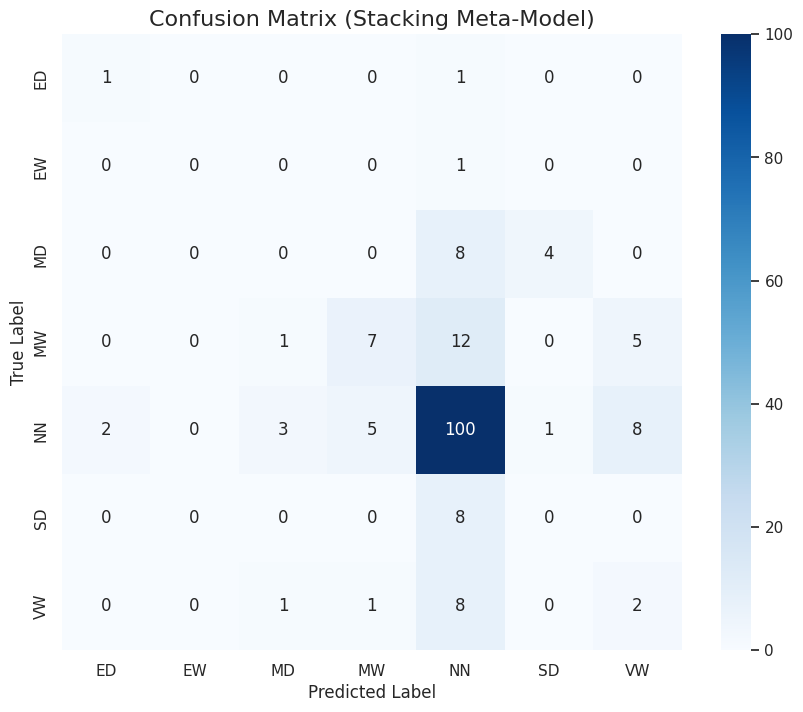

In [ ]:
df['Month'] = df['Month'].astype('int')
df['month_sin'] = np.sin(2 * np.pi * df['Month']/12.0)
df['month_cos'] = np.cos(2 * np.pi * df['Month']/12.0)
df['Month'] = df['Month'].astype('category')
# X.drop(columns=['Month'], inplace=True)

# # تبدیل ستون های دسته ای به عددی
# for col in X.columns:
#     if pd.api.types.is_categorical_dtype(X[col]):
#         X[col] = X[col].astype(int)

# --- 3. Data Splitting and Feature Selection ---
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# انتخاب خودکار بهترین تعداد ویژگی با RFECV و اعمال محدودیت حداکثر
print("\n--- Performing Automatic Feature Selection with RFECV ---")
estimator = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
# تعریف محدودیت حداکثر برای تعداد ویژگی ها (مثلا 10)
max_features_cap = 10 

# RFECV بهترین تعداد ویژگی را بر اساس معیار f1_macro پیدا می کند
selector_cv = RFECV(estimator, step=1, cv=StratifiedKFold(3), scoring='f1_macro', min_features_to_select=3, n_jobs=-1)
selector_cv = selector_cv.fit(X_train, y_train)

optimal_n_features = selector_cv.n_features_
print(f"Optimal number of features found by RFECV: {optimal_n_features}")

# اگر تعداد بهینه از سقف تعیین شده بیشتر بود، از RFE برای انتخاب سقف استفاده می کنیم
if optimal_n_features > max_features_cap:
    print(f"Optimal number ({optimal_n_features}) is greater than the cap ({max_features_cap}).")
    print(f"Selecting top {max_features_cap} features using RFE.")
    # از RFE برای انتخاب تعداد مشخص استفاده می کنیم
    selector = RFE(estimator, n_features_to_select=max_features_cap, step=1)
    selector = selector.fit(X_train, y_train)
else:
    print("Optimal number is within the cap. Using RFECV selection.")
    selector = selector_cv # از همان انتخابگر RFECV استفاده می کنیم

selected_features = X_train.columns[selector.support_]
print("Final selected features:", list(selected_features))

# اعمال ویژگی های انتخاب شده به داده ها
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)


# --- 4. Data Balancing ---
print("\nBalancing training data with SMOTE...")
min_class_size = y_train.value_counts().min()
k_neighbors = max(1, min_class_size - 1)
smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)


# --- 5. Build the Stacking Meta-Model ---
print("\nBuilding the Stacking model...")

# الف) تعریف مدل های پایه (Base Models)
estimators = [
    ('rf', RandomForestClassifier(n_estimators=400, random_state=42, class_weight='balanced', n_jobs=-1)),
    ('lgbm', LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1)),
    ('cat', CatBoostClassifier(random_state=42, verbose=0, auto_class_weights='Balanced')),
    ('xgb', XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss', n_jobs=-1)),
    # SVC به مقیاس بندی داده ها حساس است، بنابراین از Pipeline استفاده می کنیم
    ('svc', make_pipeline(StandardScaler(), SVC(random_state=42, probability=True, class_weight='balanced')))
]

# ب) تعریف مدل نهایی (Meta-Model)
final_estimator = LogisticRegression(random_state=42, class_weight='balanced')

# ج) ساخت مدل Stacking
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=final_estimator,
    cv=5,
    n_jobs=-1
)

# --- 6. Train the Stacking Model ---
print("\nTraining the final Stacking model...")
# مدل روی داده های متوازن و انتخاب شده آموزش می بیند
stacking_model.fit(X_train_resampled, y_train_resampled)

# --- 7. Prediction and Evaluation ---
print("\nEvaluating the final model...")
y_pred = stacking_model.predict(X_test_selected)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("\n--- Final Model Evaluation Metrics (Stacking Classifier) ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(report)

# --- 8. Visualization ---
sns.set_theme(style="whitegrid")

# ماتریس درهم ریختگی
cm = confusion_matrix(y_test, y_pred, labels=stacking_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=stacking_model.classes_, yticklabels=stacking_model.classes_)
plt.title('Confusion Matrix (Stacking Meta-Model)', fontsize=16)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.show()
